In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import zipfile
import os
import glob
import time
import nest_asyncio
import asyncio

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
from google.colab import drive
drive.mount('/content/drive')
output = '/content/drive/MyDrive/img_align_celeba.zip'
extract_dir = '/content/img_align_celeba'
try:
    start_time = time.time()
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
    print(f"Dataset extracted successfully in {time.time() - start_time:.2f} seconds!")
except Exception as e:
    print(f"Error extracting dataset: {e}")
    print("Ensure 'img_align_celeba.zip' is in /content/drive/MyDrive/.")
    raise

image_size = (64, 64)
image_paths = glob.glob(os.path.join(extract_dir, '/content/img_align_celeba/img_align_celeba/img_align_celeba/*.jpg'))
print(f"Found {len(image_paths)} images in the dataset")

if len(image_paths) == 0:
    raise ValueError("No images found in /content/img_align_celeba/img_align_celeba/. Ensure extraction was successful.")

image_paths = image_paths[:100000]
print(f"Limited to {len(image_paths)} images for faster processing")



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted successfully in 45.31 seconds!
Found 202599 images in the dataset
Limited to 100000 images for faster processing


In [17]:
def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    return img

In [18]:
def preview_original_images(dataset, num_images=16):
    iterator = iter(dataset)
    preview_images = next(iterator)[:num_images]  # Get first batch, up to 16 images
    preview_images = (preview_images + 1) / 2  # Rescale to [0, 1] for display
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            if i*4 + j < len(preview_images):
                axs[i, j].imshow(preview_images[i*4 + j])
                axs[i, j].axis('off')
    plt.suptitle("Preview of Original CelebA Images")
    plt.show()

In [19]:
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(128 * 8 * 8, input_dim=100))
    model.add(layers.Reshape((8, 8, 128)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.Activation('tanh'))
    return model

In [20]:
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(64, 64, 3)))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [21]:
def generate_noise(batch_size, noise_dim=100):
    return np.random.normal(0, 1, (batch_size, noise_dim))

In [22]:
async def train_dcgan():
    batch_count_total = tf.data.experimental.cardinality(dataset).numpy()
    print(f"Total batches per epoch: {batch_count_total}")
    for epoch in range(epochs):
        batch_count = 0
        start_time = time.time()
        for real_images in dataset:
            # Train discriminator with label smoothing
            real_labels = np.ones((real_images.shape[0], 1)) * 0.9  # Smooth labels
            noise = generate_noise(real_images.shape[0])
            fake_images = generator.predict(noise, verbose=0)
            fake_labels = np.zeros((real_images.shape[0], 1))
            x = np.concatenate([real_images.numpy(), fake_images]) # Convert real_images to NumPy array
            y = np.concatenate([real_labels, fake_labels])
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(x, y)

            # Train generator
            noise = generate_noise(real_images.shape[0])
            g_labels = np.ones((real_images.shape[0], 1))
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, g_labels)

            batch_count += 1
            if batch_count % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_count}/{batch_count_total}, "
                      f"D Loss: {d_loss[0]:.4f}, D Acc: {d_loss[1]:.4f}, G Loss: {g_loss:.4f}")

        print(f"Epoch {epoch+1} completed in {time.time() - start_time:.2f} seconds")

        # Step 7: Monitor training by displaying generated images every 5 epochs
        if (epoch + 1) % 5 == 0:
            noise = generate_noise(16)
            generated_images = generator.predict(noise, verbose=0)
            generated_images = (generated_images + 1) / 2  # Rescale to [0, 1]
            fig, axs = plt.subplots(4, 4, figsize=(8, 8))
            for i in range(4):
                for j in range(4):
                    axs[i, j].imshow(generated_images[i*4 + j])
                    axs[i, j].axis('off')
            plt.suptitle(f"Generated Images at Epoch {epoch+1}")
            plt.show()

Dataset pipeline created in 0.18 seconds
Displaying preview of original dataset...


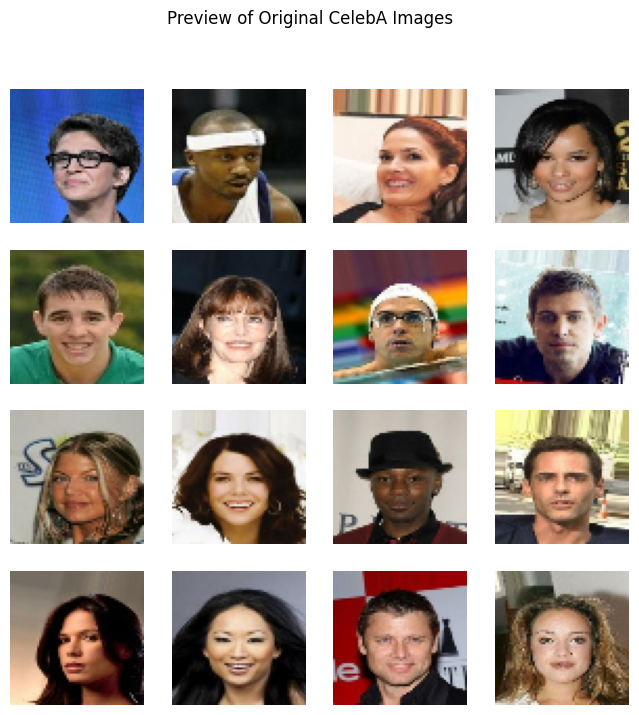

Total batches per epoch: 1563
Epoch 1/20, Batch 100/1563, D Loss: 0.2833, D Acc: 0.4662, G Loss: 2.8682
Epoch 1/20, Batch 200/1563, D Loss: 0.2678, D Acc: 0.4760, G Loss: 3.1268
Epoch 1/20, Batch 300/1563, D Loss: 0.2448, D Acc: 0.4840, G Loss: 2.2593
Epoch 1/20, Batch 400/1563, D Loss: 0.2272, D Acc: 0.4880, G Loss: 1.7107
Epoch 1/20, Batch 500/1563, D Loss: 0.2321, D Acc: 0.4899, G Loss: 1.7779
Epoch 1/20, Batch 600/1563, D Loss: 0.2345, D Acc: 0.4910, G Loss: 1.6025
Epoch 1/20, Batch 700/1563, D Loss: 0.2354, D Acc: 0.4922, G Loss: 1.4821
Epoch 1/20, Batch 800/1563, D Loss: 0.2327, D Acc: 0.4932, G Loss: 1.3148
Epoch 1/20, Batch 900/1563, D Loss: 0.2278, D Acc: 0.4939, G Loss: 1.1837
Epoch 1/20, Batch 1000/1563, D Loss: 0.2224, D Acc: 0.4945, G Loss: 1.0728
Epoch 1/20, Batch 1100/1563, D Loss: 0.2256, D Acc: 0.4946, G Loss: 1.0182
Epoch 1/20, Batch 1200/1563, D Loss: 0.2287, D Acc: 0.4946, G Loss: 0.9899
Epoch 1/20, Batch 1300/1563, D Loss: 0.2272, D Acc: 0.4951, G Loss: 0.9217
Epoc

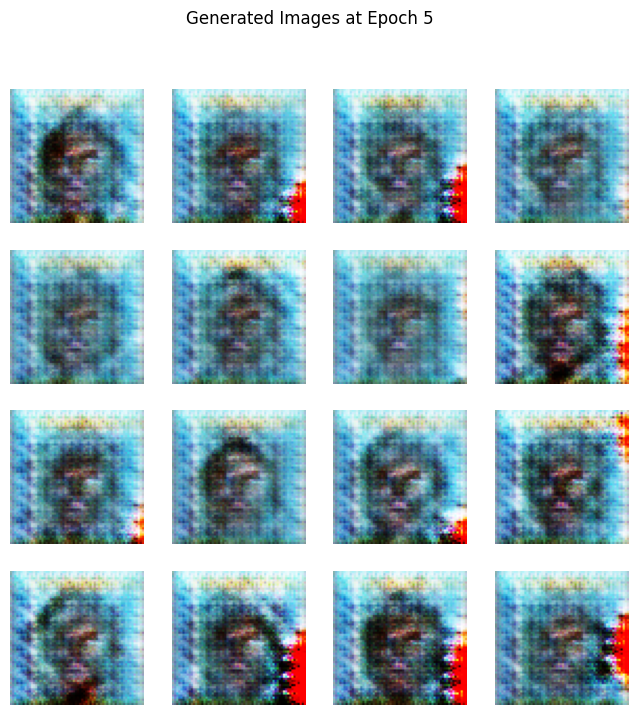

Epoch 6/20, Batch 100/1563, D Loss: 0.2066, D Acc: 0.4972, G Loss: 0.5311
Epoch 6/20, Batch 200/1563, D Loss: 0.2066, D Acc: 0.4972, G Loss: 0.5311
Epoch 6/20, Batch 300/1563, D Loss: 0.2063, D Acc: 0.4973, G Loss: 0.5297
Epoch 6/20, Batch 400/1563, D Loss: 0.2067, D Acc: 0.4973, G Loss: 0.5474
Epoch 6/20, Batch 500/1563, D Loss: 0.2063, D Acc: 0.4973, G Loss: 0.5421
Epoch 6/20, Batch 600/1563, D Loss: 0.2061, D Acc: 0.4973, G Loss: 0.5416
Epoch 6/20, Batch 700/1563, D Loss: 0.2062, D Acc: 0.4973, G Loss: 0.5476
Epoch 6/20, Batch 800/1563, D Loss: 0.2060, D Acc: 0.4973, G Loss: 0.5476
Epoch 6/20, Batch 900/1563, D Loss: 0.2060, D Acc: 0.4973, G Loss: 0.5507
Epoch 6/20, Batch 1000/1563, D Loss: 0.2056, D Acc: 0.4974, G Loss: 0.5481
Epoch 6/20, Batch 1100/1563, D Loss: 0.2057, D Acc: 0.4973, G Loss: 0.5507
Epoch 6/20, Batch 1200/1563, D Loss: 0.2055, D Acc: 0.4974, G Loss: 0.5504
Epoch 6/20, Batch 1300/1563, D Loss: 0.2052, D Acc: 0.4974, G Loss: 0.5469
Epoch 6/20, Batch 1400/1563, D Los

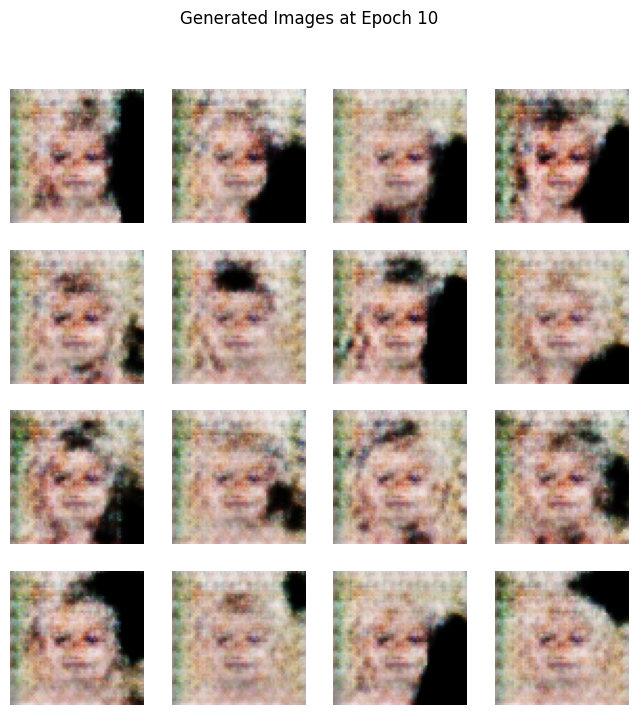

Epoch 11/20, Batch 100/1563, D Loss: 0.1986, D Acc: 0.4980, G Loss: 0.5798
Epoch 11/20, Batch 200/1563, D Loss: 0.1984, D Acc: 0.4980, G Loss: 0.5785
Epoch 11/20, Batch 300/1563, D Loss: 0.1983, D Acc: 0.4980, G Loss: 0.5757
Epoch 11/20, Batch 400/1563, D Loss: 0.1982, D Acc: 0.4981, G Loss: 0.5835
Epoch 11/20, Batch 500/1563, D Loss: 0.1982, D Acc: 0.4981, G Loss: 0.5893
Epoch 11/20, Batch 600/1563, D Loss: 0.1982, D Acc: 0.4981, G Loss: 0.5934
Epoch 11/20, Batch 700/1563, D Loss: 0.1980, D Acc: 0.4981, G Loss: 0.5907
Epoch 11/20, Batch 800/1563, D Loss: 0.1979, D Acc: 0.4981, G Loss: 0.5879
Epoch 11/20, Batch 900/1563, D Loss: 0.1981, D Acc: 0.4981, G Loss: 0.5924
Epoch 11/20, Batch 1000/1563, D Loss: 0.1981, D Acc: 0.4981, G Loss: 0.5950
Epoch 11/20, Batch 1100/1563, D Loss: 0.1980, D Acc: 0.4981, G Loss: 0.5993
Epoch 11/20, Batch 1200/1563, D Loss: 0.1980, D Acc: 0.4981, G Loss: 0.5993
Epoch 11/20, Batch 1300/1563, D Loss: 0.1978, D Acc: 0.4981, G Loss: 0.6001
Epoch 11/20, Batch 14

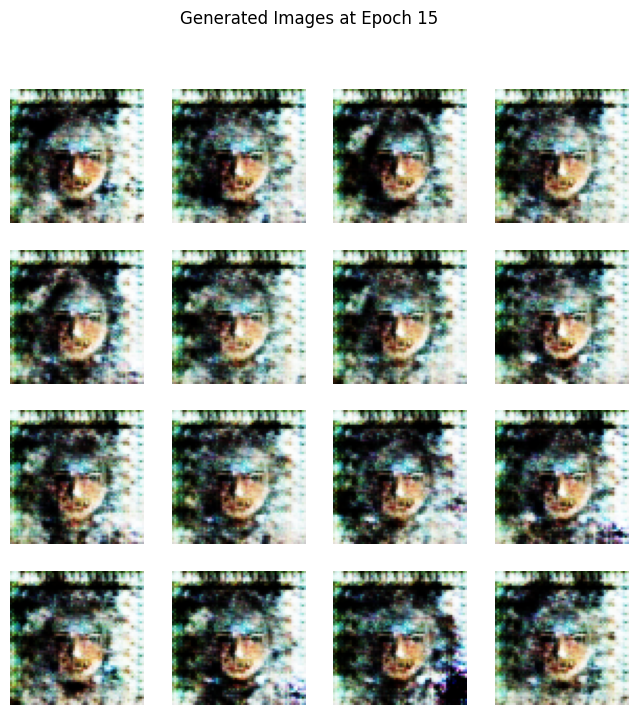

Epoch 16/20, Batch 100/1563, D Loss: 0.1957, D Acc: 0.4984, G Loss: 0.7004
Epoch 16/20, Batch 200/1563, D Loss: 0.1957, D Acc: 0.4984, G Loss: 0.7075
Epoch 16/20, Batch 300/1563, D Loss: 0.1956, D Acc: 0.4984, G Loss: 0.7054
Epoch 16/20, Batch 400/1563, D Loss: 0.1955, D Acc: 0.4984, G Loss: 0.7038
Epoch 16/20, Batch 500/1563, D Loss: 0.1954, D Acc: 0.4985, G Loss: 0.7014
Epoch 16/20, Batch 600/1563, D Loss: 0.1953, D Acc: 0.4985, G Loss: 0.7006
Epoch 16/20, Batch 700/1563, D Loss: 0.1959, D Acc: 0.4984, G Loss: 0.7054
Epoch 16/20, Batch 800/1563, D Loss: 0.1959, D Acc: 0.4984, G Loss: 0.7038
Epoch 16/20, Batch 900/1563, D Loss: 0.1959, D Acc: 0.4984, G Loss: 0.7076
Epoch 16/20, Batch 1000/1563, D Loss: 0.1958, D Acc: 0.4984, G Loss: 0.7050
Epoch 16/20, Batch 1100/1563, D Loss: 0.1957, D Acc: 0.4984, G Loss: 0.7024
Epoch 16/20, Batch 1200/1563, D Loss: 0.1957, D Acc: 0.4984, G Loss: 0.7050
Epoch 16/20, Batch 1300/1563, D Loss: 0.1959, D Acc: 0.4984, G Loss: 0.7108
Epoch 16/20, Batch 14

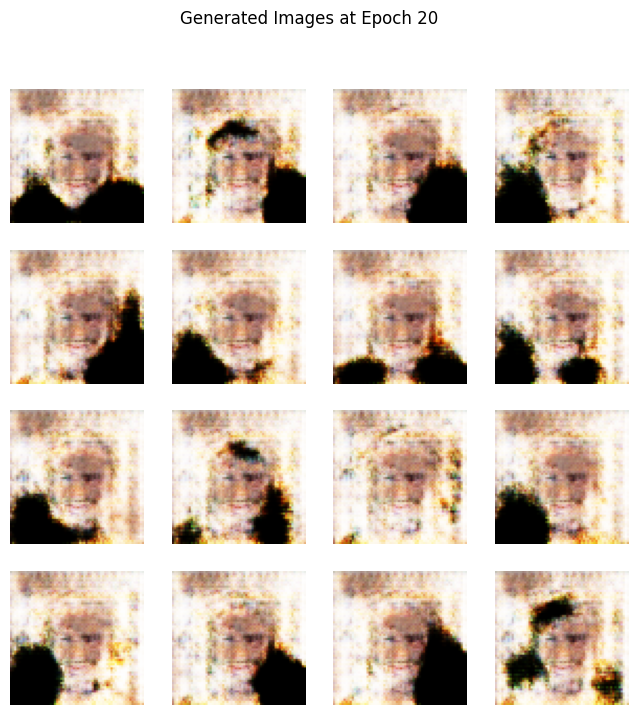

In [23]:
start_time = time.time()
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=10000).batch(64).prefetch(tf.data.AUTOTUNE)
print(f"Dataset pipeline created in {time.time() - start_time:.2f} seconds")
print("Displaying preview of original dataset...")
preview_original_images(dataset)

generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

discriminator.trainable = False
gan = models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

epochs = 20
batch_size = 64


nest_asyncio.apply()
loop = asyncio.get_event_loop()
loop.run_until_complete(train_dcgan())